# Lab 7 - Examining Feature Spaces with PCA and Clustering

## Background

In class, we talked about how machine learning techniques require vectors, and you must first perform **feature extraction** to create **feature vectors** if your data is not already in vector form. I mentioned that this is considered outside the domain of machine learning, but that's not entirely true, especially in recent years. In fact, most modern ML techniques that work on data that's not naturally represented as vectors (e.g., text, images, audio) begin with a very simple vector representation of the raw signal, then **learn** how to extract good features from them.

For example, in computer vision we used to start by detecting corners, edges, or other low-level visual features in images, then shoehorn those into vectors, which we would then use machine learning to classify. Nowadays, we typically flatten the image into a vector (pretty much just `np.flatten`) and use models that learn how to go from raw pixels to the answers we want.

An early example of such a model is called LeNet, and it was designed to work on the handwritten digit recognition problem. This model works in **layers**, where each layer transforms the image into a new set of features, until finally the last layer spits out a classification; in our case, it's trying to decide which of `range(10)` a handwritten digit represents. Here's a diagram of LeNet- the details aren't important, so don't worry about the specifics - but notice that the model is drawn in layers: ![](https://facultyweb.cs.wwu.edu/~wehrwes/courses/data311_21f/lab7/lenet5.png)

When trained well, the practical effect of models like this (these are called "convolutional neural networks", by the way) is that **the features become more and more "well-organized" after each layer**. Unfortunately, each intermediate feature representation is high-dimensional, so we can't directly see this. One of the uses we discussed in class for PCA is for visualizing high-dimensional things. In this lab, we're going to put this to use to visualize the the features at each step and see if we observe a trend towards a more orderly set of features.

Let's get some useful imports out of the way - if you need more libraries, import them here:

In [139]:
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## The Data

For our purposes, the code for the LeNet model can be abstracted to something like this:

```python
inputs = load_digits()
conv1_features = conv1(inputs)
conv2_features = conv2(conv1_features)
fc1_features = fc1(conv2_features)
fc2_features = fc2(fc1_features)
fc3_features = fc3(fc2_features)
```

The specifics of the functions aren't important to us right now. Notice that each function simply takes the output of the prior one, and transforms it in some way to produce the next set of features.

Let's load up two files that give us access to those variables above, as well as the ground-truth digit labels, for 5400 example digits:

In [2]:
# adapted from https://stackoverflow.com/a/61716809
def np_load_from_url(url):
    response = requests.get(url)
    response.raise_for_status() # throw an error if it didn't work
    return np.load(io.BytesIO(response.content))

In [3]:
base_url = "https://facultyweb.cs.wwu.edu/~wehrwes/courses/data311_23w/data/mnist/"
labels = np_load_from_url(base_url + "labels.npz")["labels"]
features = dict(np_load_from_url(base_url + "features.npz"))

In [4]:
print(labels.shape, labels[:10])

(5400,) [1 5 6 5 2 0 0 8 1 7]


We can see that there are 5400 labels, and each one says what digit a given example actually represents.

In [5]:
print(features.keys())

dict_keys(['input', 'conv1', 'conv2', 'fc1', 'fc2', 'fc3'])


The `features` dict contains values for each of the variables described in the pseudocode above. The `input` just contains the input images, flattened into vectors:

In [6]:
features["input"].shape

(5400, 784)

Notice this is, as per tradition, an $n \times d$ matrix - each of 5400 images have 784 pixels (originally, they were 28x28). We can visualize a few images to see what they look like:

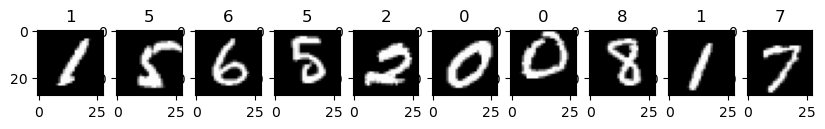

In [7]:
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(1,10,i+1)
    in_image = features["input"][i].reshape((28, 28))
    plt.imshow(in_image, cmap="gray")
    plt.title(str(labels[i]))

Notice the labels (above each image) line up with the labels we saw above.

The remaining features don't have such a nice visualizeable interpretation - we're stuck just thinking of them as high-dimensional vectors. Let's see their dimensionality:

In [8]:
pd.DataFrame({"Feature set" : features.keys(),
              "Shape": [f.shape for f in features.values()]})

,Feature set,Shape
0,input,"(5400, 784)"
1,conv1,"(5400, 3456)"
2,conv2,"(5400, 1024)"
3,fc1,"(5400, 120)"
4,fc2,"(5400, 84)"
5,fc3,"(5400, 10)"


## Your Tasks

### Part 1: Visualizing the Feature Spaces

**1.1**: Your first (and primary) job in Part 1 is to take each of these collections of feature vectors (I'll call them "feature sets" from here on out), use PCA to reduce their dimensionality to two, transform the features into their 2D representation, and visualize them in a scatterplot; color-code the points in the scatterplot by the ground-truth label (stored in `labels`). This will result in 6 scatterplots, one for each feature set.

#### PCA Refresher
Recall that you can compute PCA using `scikit-learn` by instantiating a `PCA` object, passing it the number of components you want to fit:
```python
pca = PCA(n_components=d_prime)
```
then calling its `fit` method on the $n \times d$ data matrix:
```python
pca.fit(X)
```

This computes the `d_prime` component vectors that point in the directions of greatest variance, accessible via `pca.components_`. To actually reduce the dimensionality of the data, you can convert your data matrix into a new `d_prime`-dimensional data matrix (which lives in the space spanned by the `d_prime` component vectors). In `sklearn`, you can accomplish this using the PCA object's `transform` method:
```python
Xprime = pca.transform(X)
```
where `Xprime.shape` would now be `(n, d_prime)`. You can access the fraction of variance explained by each component using `pca.explained_variance_ratio_`.

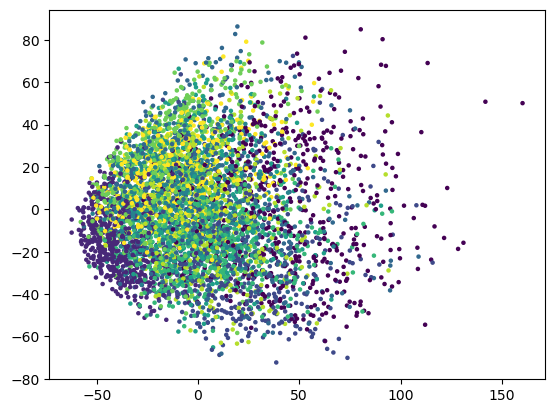

In [39]:
# TODO 1.1 - your code here

# keep 2 components 
pca = PCA(n_components=2)

c1 = pca.fit_transform(features['conv1'])
c1_plt = plt.scatter(c1[:,0], c1[:, 1], c=labels, s=5)
print(c1_plt)


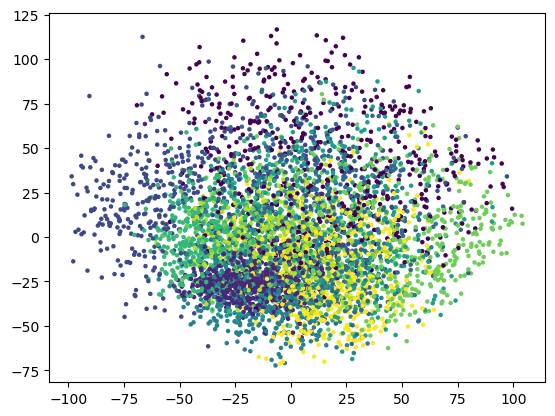

In [40]:
c2 = pca.fit_transform(features['conv2'])
c2_plt = plt.scatter(c2[:,0], c2[:, 1], c=labels, s=5)
print(c2_plt)

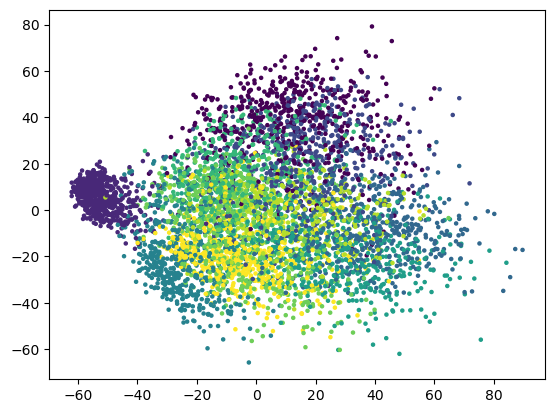

In [41]:
c2 = pca.fit_transform(features['fc1'])
c2_plt = plt.scatter(c2[:,0], c2[:, 1], c=labels, s=5)
print(c2_plt)

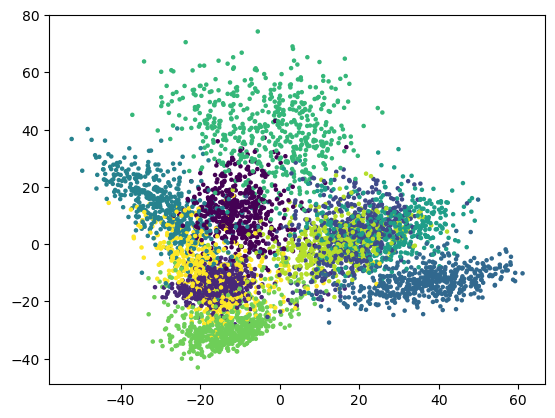

In [42]:
c2 = pca.fit_transform(features['fc2'])
c2_plt = plt.scatter(c2[:,0], c2[:, 1], c=labels, s=5)
print(c2_plt)

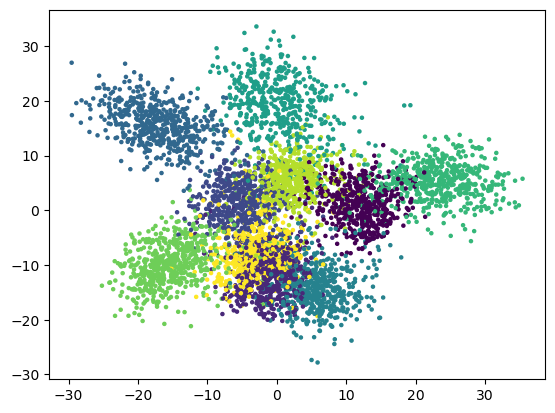

In [43]:
c2 = pca.fit_transform(features['fc3'])
c2_plt = plt.scatter(c2[:,0], c2[:, 1], c=labels, s=5)
print(c2_plt)

**1.2** You'll notice that in the plot for the final feature set (`fc3`), there is still considerable overlap among points in different classses. Does this imply that if we run some kind of classification or clustering scheme on the **original 10d** `fc3` feature vectors, we should expect it to be impossible to get very high accuracy? Why or why not?

**TODO 1.2** - Write your answer to task 1.2 here.

# TODO 1.2 

Although classification and clustering techniques can be useful in identifying collections of data that are close together/similar, or classifying data by certain parameters/labels, there is only so much overlap that can be reduced through either technique. I think some kind of classification or clustering technique may increase the accuracy of the feature set, though I wouldnt expect a sudden jump to 'very' high accuracy from clustering/classification of this feature set(alone). Again, it's not to say that classification or clustering wouldnt improve accuracy at all, just that i'm not sure it would result in a set thats considerably higher in accuracy. Particularly for some of the classes in fc3, it would be difficult even with the implimentation of a clustering or classification scheme to seperate(considering the amount of overlap), while some other classes that show little overlap would likely show even less after classification or clustering which could improve its accuracy for those clusters. I was slightly confused by the term impossible and 'very' high accuracy because they arent exact terms/parameters to go by, however I tried to give an explanation on how the use of classification/clustering may affect the models accuracy based on the presence of overlap in the set. 

#### Estimating Intrinsic Dimensionality

Above, we used PCA to visualize how "orderly" the feature space is as it goes through the model. Now, let's look at this in a slightly more quantitative way. We talked about **intrinsic dimensionality** as the minimum number of dimensions needed to represent a set of data. PCA also gives us a coarse way to estimate the intrinsic dimensionality by looking at the amount of variance explained by each component. For example, if the vast majority of the variance is explained by the first two components, the intrinsic dimensionality is probably around 2.

**1.3**: For each of the feature sets, compute up to 100 PCA components (for features with $d < 100$, compute all $d$ components) and make a plot to visualize the fraction of the variance explained by each of the first K components as a function of K (you may find the `np.cumsum` function helpful here).

**1.4**: Let's (arbitrarily) define our estimate of intrinsic dimensionality to be the number of components needed to explain at least 90% of the variance. For each feature set, what is its intrinsic dimensionality esimate based on this definitions? Show your results in a nicely formatted table and/or a sensibly designed plot.

Text(0.5, 1.0, 'Input')

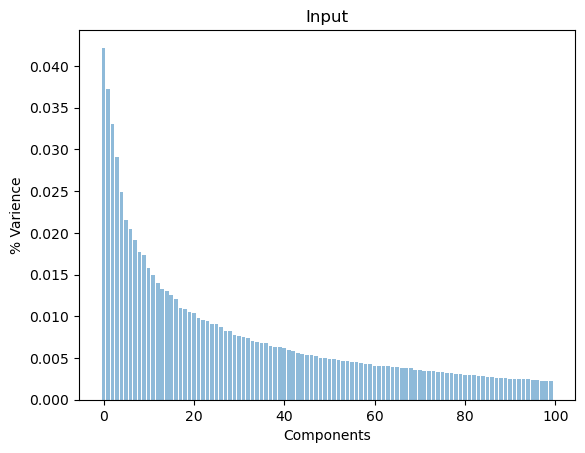

In [132]:
# TODO 1.3 and 1.4 - your code and results here
# for a few of these i started with n components = d 
#   i then visually reduced the amount of components once the components became what appeared to be somewhat statistically insignificant 
# ^ doesnt apply for input-conv2 since i kept the components at 100 for those

# keep components at 100 for first few feature sets that are >100
pc_hun = PCA(n_components=100)
sc = StandardScaler()
#fit feature set
sc.fit(features['input'])
input_std = sc.transform(features['input'])
input_pc = pc_hun.fit_transform(input_std)
# cumsum explained varience ratio
exp = pc_hun.explained_variance_ratio_
cum_sum = np.cumsum(exp)

#plot
plt.bar(range(0,len(exp)), exp, alpha=0.5)
plt.xlabel('Components')
plt.ylabel('% Varience')
plt.title('Input')

Text(0.5, 1.0, 'Conv1')

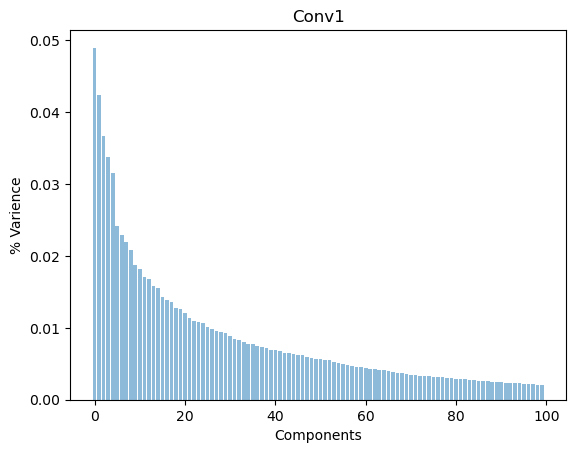

In [134]:
sc.fit(features['conv1'])
conv1_std = sc.transform(features['conv1'])
conv1_pc = pc_hun.fit_transform(conv1_std)
conv1_exp = pc_hun.explained_variance_ratio_

cum_sum = np.cumsum(conv1_exp)
plt.bar(range(0,len(conv1_exp)), conv1_exp, alpha=0.5)
plt.xlabel('Components')
plt.ylabel('% Varience')
plt.title('Conv1')

Text(0.5, 1.0, 'Conv2')

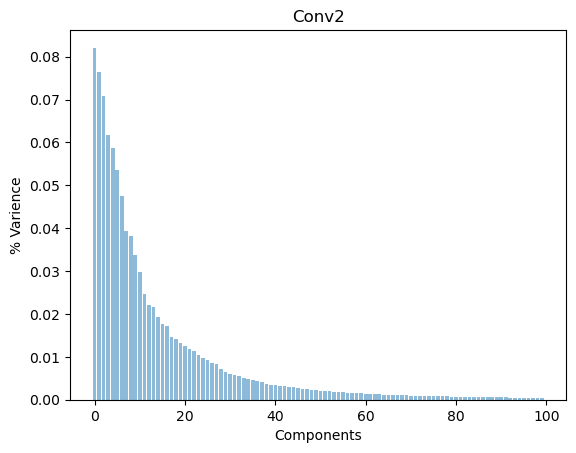

In [135]:
sc.fit(features['conv2'])
conv2_std = sc.transform(features['conv2'])
conv2_pc = pc_hun.fit_transform(conv2_std)
conv2_exp = pc_hun.explained_variance_ratio_

cum_sum = np.cumsum(conv2_exp)
plt.bar(range(0,len(conv2_exp)), conv2_exp, alpha=0.5)
plt.xlabel('Components')
plt.ylabel('% Varience')
plt.title('Conv2')

Text(0.5, 1.0, 'Fc1')

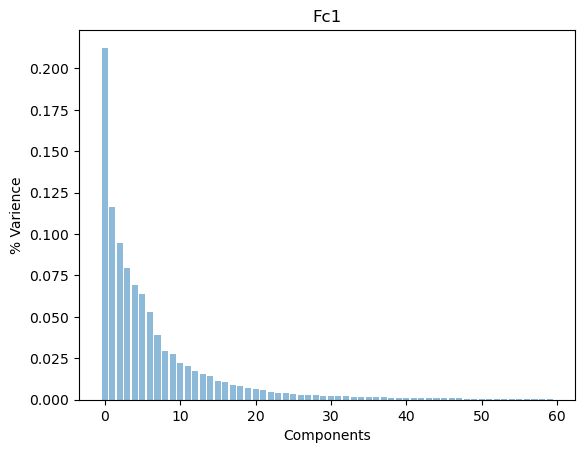

In [136]:
pc_fc1 = PCA(n_components=60)
sc.fit(features['fc1'])
fc1_std = sc.transform(features['fc1'])
fc1_pc = pc_fc1.fit_transform(fc1_std)
exp = pc_fc1.explained_variance_ratio_

cum_sum = np.cumsum(exp)
plt.bar(range(0,len(exp)), exp, alpha=0.5)
plt.xlabel('Components')
plt.ylabel('% Varience')
plt.title('Fc1')

Text(0.5, 1.0, 'Fc2')

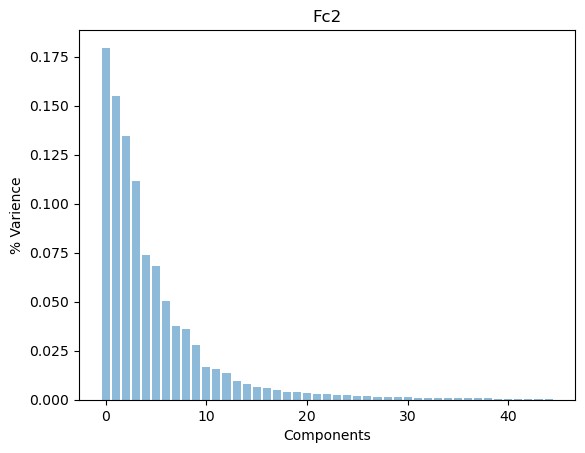

In [137]:
pc_fc2 = PCA(n_components=45)
sc.fit(features['fc2'])
fc2_std = sc.transform(features['fc2'])
fc2_pc = pc_fc2.fit_transform(fc2_std)
fc2_exp = pc_fc2.explained_variance_ratio_

cum_sum = np.cumsum(fc2_exp)
plt.bar(range(0,len(fc2_exp)), fc2_exp, alpha=0.5)
plt.xlabel('Components')
plt.ylabel('% Varience')
plt.title('Fc2')

Text(0.5, 1.0, 'Fc3')

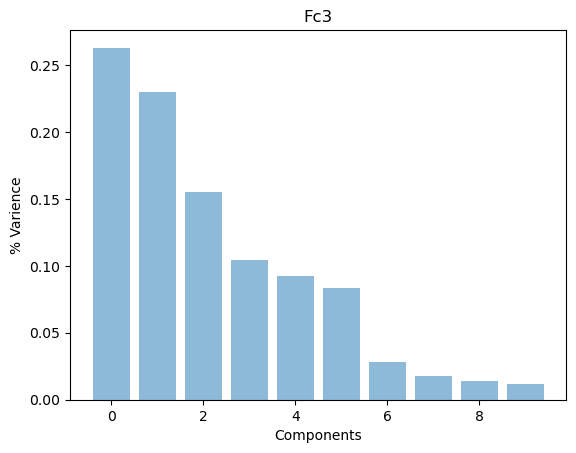

In [138]:
pc_fc3 = PCA(n_components=10)
sc.fit(features['fc3'])
fc3_std = sc.transform(features['fc3'])
fc3_pc = pc_fc3.fit_transform(fc3_std)
fc3_exp = pc_fc3.explained_variance_ratio_

cum_sum = np.cumsum(fc3_exp)
plt.bar(range(0,len(fc3_exp)), fc3_exp, alpha=0.5)
plt.xlabel('Components')
plt.ylabel('% Varience')
plt.title('Fc3')

In [149]:
# getting intrinsic dimensionality
# creating empty lists to store components and varience ratio for said components
num_comp = []
perc_var = []

# get number of components that preserves more than 90% of variance for each feature set
for i in features.values():
    p = PCA(n_components=0.90, svd_solver='full')
    x = p.fit_transform(i)
    num_comp.append(p.n_components_)
    perc_var.append(p.explained_variance_ratio_.sum())

In [151]:
# load dataframe of both component counts and corresponding % of varience 
intr_dim = pd.DataFrame({'Feature Set':['input','conv1','conv2','fc1','fc2','fc3']})

intr_dim['Components'] = num_comp
intr_dim['Varience Percent'] = perc_var
intr_dim['Varience Percent'] = intr_dim['Varience Percent']*100
intr_dim.style.set_caption('Number of Components Explaining at Least 90% of Varience')


,Feature Set,Components,Varience Percent
0,input,101,90.066109
1,conv1,54,90.078972
2,conv2,35,90.276627
3,fc1,16,90.523354
4,fc2,10,90.165199
5,fc3,6,92.908936


### Part 2

We'll now use clustering to create a different assessment of the quality of the feature sets. The general idea here is that if we run unsupervised clustering on some features, datapoints with the same (true) label should end up clustered together if the features are good. We can use this to get a slightly more quantitative quality estimate than we did with PCA above, and one that does not require us to lose dimensionality.



#### K-Means Clustering Refresher

Recall that you can do k-means clustering using `scikit-learn` by instantiating a `KMeans` object, passing it the number of clusters you want to fit:
```python
km = KMeans(n_clusters=k)
```
then calling its `fit` method on the $n \times d$ data matrix:
```python
km.fit(X)
```

You can get at the cluster centers themselves via `km.cluster_centers_`, and the cluster center assignments are accessible as `km.labels_` (these are the same as what would be returned by `km.predict(X)`.



#### Confusion Matrices

Once we cluster a set of features, we can check whether most of the 0's ended up in a single cluster, and so on for all the true labels. We'll do this by making a **confusion matrix**: this is a `d x d` matrix `M` where `M[i,j]` is the number of datapoints whose *true* label is `i` got assigned to cluster center `j`.

**2.1** Complete the following function, which takes a set of features and labels, performs k-means clustering with $k=10$ (this part does not make use of the labels), then and builds a confusion matrix relating cluster centers to true labels.

In [323]:
def make_confusion(features, labels):
# setting k = 10
  km = KMeans(n_clusters=10)
  for x in features:
      # reshaping array 
      km.fit(x.reshape(-1,1), labels)
      # getting cluster centers and cluster assignments
      cluster_labels = km.labels_
      cluster_centers = km.cluster_centers_
      # since feature sets change in size -> have labels match size
      y = labels[:len(cluster_labels)]
      return confusion_matrix(y,cluster_labels)
  """ Cluster features (n, d) and generate a confusion matrix with the
  ground truth labels. features is (n, d); labels is (n,). Returns a (d, d)
  confusion matrix."""
  # TODO 2.1 - your code here

Let's test this out on FC3, where we hope things will be quite well-behaved. We'll use a handy plotting utility from sklearn that displays confusion matrices nicely:

c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


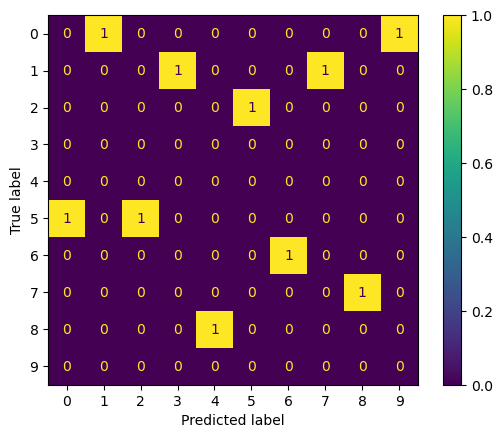

In [324]:
conf = make_confusion(features['fc3'], labels)
sklearn.metrics.ConfusionMatrixDisplay(conf).plot()

That looks good (10 bright squares and the rest mostly dark), but it would be great if cluster center 0 corresponded to label 0. Since the cluster center labels are arbitrary, we can relabel things to make a prettier picture. Here's a function that performs an optimal matching between cluster centers and true labels:

In [282]:
def rearrange_confusion(conf):
  

  """ Match cluster centers to labels so that the ideal confusion matrix
  is diagonal. """
  ri, ci = scipy.optimize.linear_sum_assignment(conf, maximize=True)
  return conf[:, ci]

Let's take a look now:

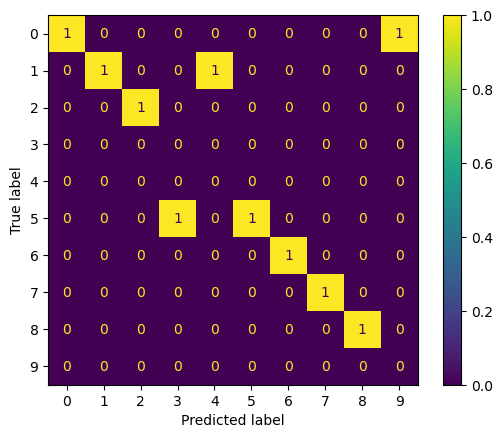

In [325]:
conf_fc3 = rearrange_confusion(conf)
sklearn.metrics.ConfusionMatrixDisplay(conf_fc3).plot()

Now we'll use this to look at all 6 of our feature sets.

**2.2** Make and plot a (correctly rearranged) confusion matrix for each of the 6 feature sets.

c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


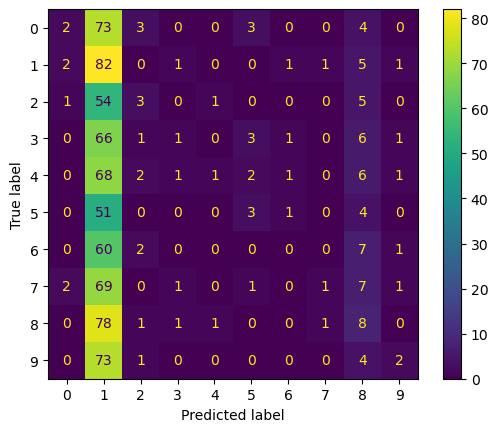

In [326]:
# TODO 2.2 - your code and plots here

# input confusion matrix -looks awful
# do this same process for all feature sets
conf_arr_input = make_confusion(features['input'], labels)
conf_input = rearrange_confusion(conf_arr_input)
sklearn.metrics.ConfusionMatrixDisplay(conf_input).plot()

c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


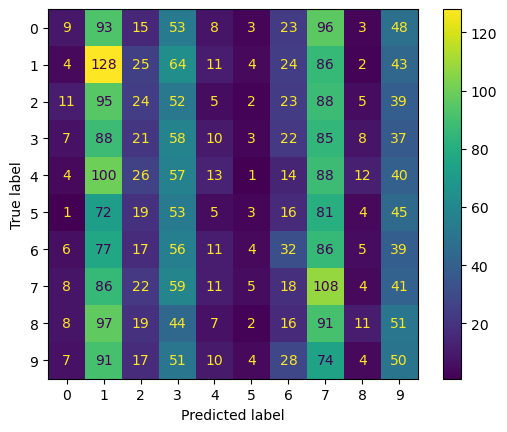

In [327]:
conf_arr_conv1 = make_confusion(features['conv1'], labels)
conf_conv1 = rearrange_confusion(conf_arr_conv1)
sklearn.metrics.ConfusionMatrixDisplay(conf_conv1).plot()

c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


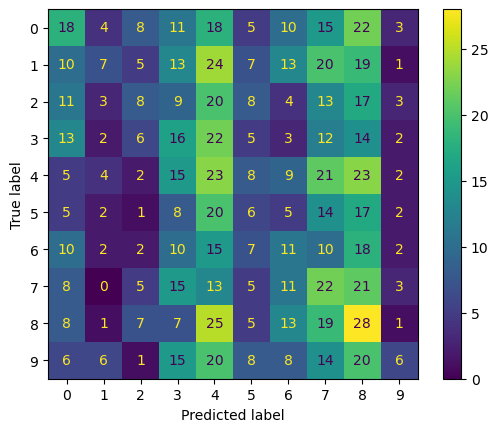

In [328]:
conf_arr_conv2 = make_confusion(features['conv2'], labels)
conf_conv2 = rearrange_confusion(conf_arr_conv2)
sklearn.metrics.ConfusionMatrixDisplay(conf_conv2).plot()

c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


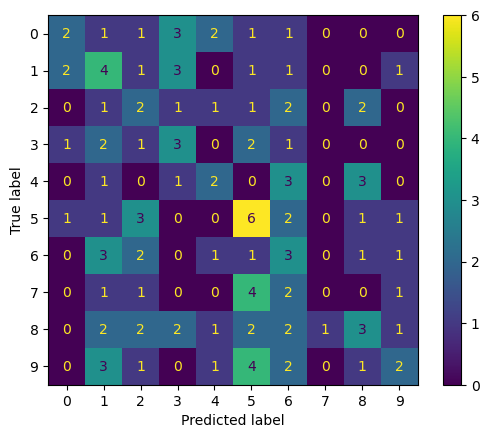

In [329]:
conf_arr_fc1 = make_confusion(features['fc1'], labels)
conf_fc1 = rearrange_confusion(conf_arr_fc1)
sklearn.metrics.ConfusionMatrixDisplay(conf_fc1).plot()

c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Meghan\miniconda3\envs\DataVis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


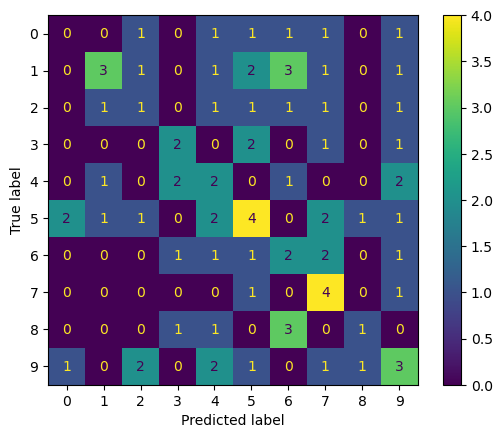

In [330]:
conf_arr_fc2 = make_confusion(features['fc2'], labels)
conf_fc2 = rearrange_confusion(conf_arr_fc2)
sklearn.metrics.ConfusionMatrixDisplay(conf_fc2).plot()

Now, let's get quantitative. One measure of how well a feature set performs is how often the correct label is assigned.

**2.3** Using the rearranged confusion matrices, calculate the fraction of datapoints that were assigned to the "correct" cluster center. Make a plot showing how this accuracy measure performs on the different feature sets.

Text(0, 0.5, 'Score')

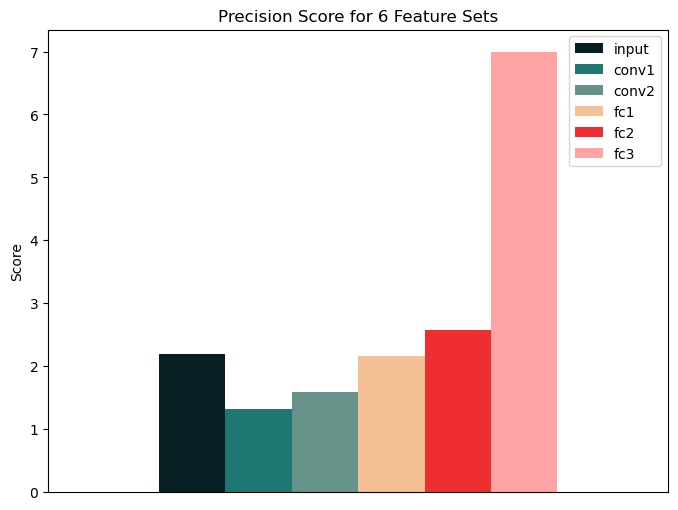

In [417]:
# TODO 2.3 - your code and plot here
# getting precision through the correct values (true positive) from the confusion matrix
precision_list = []
# decided to make a function for this process bc why not
def prec(matrix):
    tp = np.diag(matrix)
    precision = np.sum(tp / np.sum(matrix, axis=0))
    precision_list.append(precision)

# load data from each feature set
prec(conf_input)
prec(conf_conv1)
prec(conf_conv2)
prec(conf_fc1)
prec(conf_fc2)
prec(conf_fc3)

precision_df = pd.DataFrame(columns=['input','conv1','conv2','fc1','fc2','fc3'])
precision_df.loc[len(precision_df)] = precision_list


prec = precision_df.plot.bar(figsize=(8,6), rot=0, color={'input':'#071E22', 'conv1':'#1D7874', 'conv2':'#679289',
                                               'fc1':'#F4C095', 'fc2':'#EE2E31', 'fc3':'#FFA3A5'}, width=0.9)
plt.xticks([])
plt.title('Precision Score for 6 Feature Sets')
plt.ylabel('Score')
